# Python code used for the implementation of the EM algorithm
## by Martin Metodiev, Ariane Fazeny, Daniela Bernhard
### 1 Implementation

For the implementation and visualization of the EM Algorithm, parts of the sample code from the lecture were used. 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from math import sqrt, pi
from matplotlib.widgets import Slider, Button
np.random.seed(3)

colors = ["#cccc00", "#006600", "m", "b", "r"]

This EM Algorithm has been programmed for NxM-dimensional data sets. We assume a gaussian mixture

\begin{align}\sum^K_{k=1}\pi_k\mathcal{N}(x|\mu_k,\Sigma_k)\end{align}

Names of the parameters:

$\textbf{data}$: NxM dimensional data set

$\textbf{K}$: Number of clusters

$\textbf{m}$: Matrix of means $\mu_1,\dots,\mu_K$

$\textbf{random_choice}$: If True, parameters are initialized randomly.

$\textbf{Sigma}$: Cov-matrix Sigma=$\Sigma=\Sigma_1,\dots,\Sigma_K$

$\textbf{gamma}$: NxK Matrix of responsibilities $\gamma_{nk}$

$\textbf{p}$: the a priori distribution $\pi_1,\dots,\pi_K$

We divide the EM algorithm into several steps:

#### 1.1 Initialization

We randomly initialize all of the parameters:

m=$\mu_1,\dots,\mu_K$ are assigned realizations of the uniform distribution on ranging from the minimum to the maximum value of all data points.

Sigma=$3\cdot I$ where $I$ denots the unit matrix.

gamma=$1/K\cdot O$ where $O$ is an NxK matrix consisting of only 1s.

p=the discrete uniform distribution on $\{1,\dots,K\}$

In [2]:
def initialize(N, M, random_choice = True, sigma_def = 3):
    #random initialization
    if random_choice == True:
        for mm in range(M):
            m[:, mm] = np.random.uniform(np.min(data[:,mm]), np.max(data[:,mm]), (K, ))
    Sigma = [sigma_def*np.eye(M) for kk in range(K)]
    gamma = 1/K*np.ones((N,K), dtype=np.int32)
    p = 1/K*np.ones((K,))
    return m, Sigma, gamma, p

#### 1.2 Update of the loglikelihood

We update the loglikelihood function by adding the joint distribution.

In [3]:
def Update_log_likelihood(data, p, Sigma, m):
    likeli_new = 0
    for n in range(data.shape[0]):
        x = data[n, :]
        terms = np.array([p[k]*1/sqrt((2*pi)**M*np.linalg.det(Sigma[k])) * np.exp(-0.5*(x-m[k,:]) @ (np.linalg.inv(Sigma[k]) @ (x-m[k,:]))) for k in range(K)])
        likeli_new = likeli_new + np.log(np.sum(terms))
    #likeli_new = 1/N * likeli_new
    return likeli_new
    

#### 1.3 E-Step

The E-step is executed exactly as described in the algorithm.

In [4]:
def E_step(data, p, Sigma, m, gamma):
    for n in range(data.shape[0]):
        x = data[n, :]
        terms = np.array([p[k]*1/sqrt((2*pi)**M*np.linalg.det(Sigma[k])) * np.exp(-0.5*(x-m[k,:]) @ (np.linalg.inv(Sigma[k]) @ (x-m[k,:]))) for k in range(K)])
        gamma[n, :] = terms/np.sum(terms)
    return gamma

#### 1.4 M-Step

The M-Step is also executed as described.

In [5]:
def M_Step(data, p, Sigma, m, gamma):
    means = np.dot(gamma.T, data)
    Nk = [np.sum(gamma[:, k]) for k in range(K)]
    m_new = np.array([ means[k, :]/Nk[k] for k in range(K)])

    m = m_new

    Sigma_new = [np.zeros((M, M)) for k in range(K)]
    for k in range(K):
        Sigmak = np.zeros((M,M))
        for n in range(N):
            x = data[n, :]
            Sigmak += gamma[n, k] * np.dot((x-m[k,:]).reshape((-1,1)), (x-m[k,:]).reshape((1,-1)))
        Sigma_new[k] = Sigmak/Nk[k] 

    Sigma = [np.copy(Sigma_new[k]) for k in range(K)]

    p = np.array([Nk[k]/N for k in range(K)])
    
    return m, Sigma, p

#### 1.5 Plots via Matplotbib

Code from the exercises was used to visualize the algorithm. Legend:

$\textbf{Covariance ellipse}$: Grey

$\textbf{Color}$: The more similar the color is to the cluster, the higher is the probability that it belongs to said cluster.

In [6]:
# matplotlib ellipse plotter (from matplotlib.org)

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)


def plot_ellipse(mean, cov, ax, n_std=1.0, color='k', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """

    #cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        color=color, alpha = 0.05,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])
    

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def drawfig(it, m, m_history, n_iter, Sigma, Sigma_history, p, p_history, gamma, gamma_history):
        plt.figure()
        #ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        #ax1.set_xlim([xmin-0.5, xmax+0.5])
        #ax1.set_ylim([ymin-0.5, ymax+0.5])
        m_now = m_history[it+1, :, :]
        m_old = m_history[it, :, :]
        
        gamma_now = gamma_history[it+1, :]
        Sigma_now = Sigma_history[it+1]
        Sigma_old = Sigma_history[it]

        
        #for k in range(K):
            #ax1.plot(m_old[k, 0], m_old[k, 1], color = colors[k], marker = "s", markeredgecolor="k", markersize=10)
        
        
        
        #if K == 2: # linear interpolation between colors possible
            #mixcoeffs = gamma_now[:, 1]
            #sc = ax1.scatter(data[:, 0], data[:, 1], c=[colorFader(colors[0],colors[1],mixc) for mixc in mixcoeffs], s=45, zorder=2)
            
        #else: # for more clusters we can only color with the dominant cluster :(
            #cs_index = [int(list(gamma_now[n, :]).index(max(gamma_now[n, :]))) for n in range(N)]
            #ax1.scatter(data[:, 0], data[:, 1], c=[colors[csi] for csi in cs_index], s=45, zorder=2)
            
        #for k in range(K):
            #plot_ellipse(m_old[k, :], Sigma_old[k], ax1)
            #plot_ellipse(m_old[k, :], Sigma_old[k], ax1, n_std=2.0)
        

        
        
        ax2.set_xlim([xmin-0.5, xmax+0.5])
        ax2.set_ylim([ymin-0.5, ymax+0.5])
        
        for k in range(K):
            ax2.plot(m_now[k, 0], m_now[k, 1], color = colors[k], marker = "s", markeredgecolor="k", markersize=10)
                        
                        
                        
                            
        if K == 2: # linear interpolation between colors possible
            mixcoeffs = gamma_now[:, 1]
            sc = ax2.scatter(data[:, 0], data[:, 1], c=[colorFader(colors[0],colors[1],mixc) for mixc in mixcoeffs], s=45, zorder=2)
            
        else: # for more clusters we can only color with the dominant cluster :(
            cs_index = [int(list(gamma_now[n, :]).index(max(gamma_now[n, :]))) for n in range(N)]
            ax2.scatter(data[:, 0], data[:, 1], c=[colors[csi] for csi in cs_index], s=45, zorder=2)
        #for k in range(K):
            #plot_ellipse(m_now[k, :], Sigma_now[k], ax2)
            #plot_ellipse(m_now[k, :], Sigma_now[k], ax2, n_std=2.0)
        
        #ax1.set_title("iteration " + str(it) + ": after assignment")
        ax2.set_title("iteration " + str(it) + ": after update")
        #plt.title("iteration " + str(it) + ": after update")
        # ax1.set_aspect('equal')
        # ax2.set_aspect('equal')
        plt.show()

def plotting(ret, just):
        #if ret["success"] == True:
        m = ret["m"]
        m_history = ret["m_history"]
    
        n_iter = m_history.shape[0] - 1
    
        Sigma = ret["Sigma"]
        Sigma_history = ret["Sigma_history"]
        p = ret["p"]
        p_history = ret["p_history"]
        gamma = ret["gamma"]
        gamma_history = ret["gamma_history"]
        likelihood = ret['likelihood']
        print(first)
        print(second)
        #print(m_history)
        #print(Sigma_history)
        #print(likelihood)
            
        plt.ion()
        #if ret["success"] == True:
        if just_last == True:
            drawfig(m_history.shape[0]-3, m, m_history, n_iter, Sigma, Sigma_history, p, p_history, gamma, gamma_history)
            #initial      
            plt.figure()
            ax1 = plt.subplot(1,2,1)
            ax1.set_xlim([xmin-0.5, xmax+0.5])
            ax1.set_ylim([ymin-0.5, ymax+0.5])
            ax1.scatter(first[:, 0], first[:, 1])
            ax1.scatter(second[:, 0], second[:, 1])
            if option == 1:
                ax1.scatter(third[:, 0], third[:, 1])
            #ax1.set_title("initial clusters")
            plt.show()
    
            #likelihood
            plt.figure()
            ax1 = plt.subplot(1,1,1)
            ax1.set_xlim([0, len(likelihood)-1])
            ax1.set_ylim([min(likelihood)-1, max(likelihood)+1])
            plt.plot(likelihood)
            #ax1.set_title("values of loglikelihood")
            plt.show()
        else:
            for it in range(m_history.shape[0]-2):
                drawfig(it, m, m_history, n_iter, Sigma, Sigma_history, p, p_history, gamma, gamma_history)
                #initial      
                plt.figure()
                ax1 = plt.subplot(1,2,1)
                ax1.set_xlim([xmin-0.5, xmax+0.5])
                ax1.set_ylim([ymin-0.5, ymax+0.5])
                ax1.scatter(first[:, 0], first[:, 1])
                ax1.scatter(second[:, 0], second[:, 1])
                if option == 1:
                    ax1.scatter(third[:, 0], third[:, 1])
                ax1.set_title("initial clusters")
                plt.show()

                #likelihood
                plt.figure()
                ax1 = plt.subplot(1,1,1)
                ax1.set_xlim([0, len(likelihood)-1])
                ax1.set_ylim([min(likelihood)-1, max(likelihood)+1])
                plt.plot(likelihood)
                ax1.set_title("values of loglikelihood")
                plt.show()

#### 1.6 Some test Cases

In [7]:
 def Test_Cases(option = 1):
    # Test cases. Fiddle with parameters:
    n_iter = 100
    K = 2 # number of clusters
    
    option = 7 # select scenario 
    
    # description of options:
    # option 1: three clusters with few points
    # option 2: two elongated clusters
    # option 3: one large, one small cluster
    # option 4: small, dense cluster within large cluster
    # option 5: two ring-shaped clusters
    # option 6: faithful.csv
    
    

    # END parameters TODO: plot, von welcher normalverteilung Daten ursprünglich erstellt
    
    if option == 1:
        mean1 = np.array([1,0])
        sig1 = 0.05*np.eye(2)
        mean2 = np.array([0, 1])
        sig2 = 0.05*np.eye(2)
        mean3 = np.array([2, 1])
        sig3 = 0.05*np.eye(2)
        first = np.random.multivariate_normal(mean1, sig1, 5)
        second = np.random.multivariate_normal(mean2, sig2, 5)
        third = np.random.multivariate_normal(mean3, sig3, 5)
        data = np.concatenate((first, second, third))
        m = np.zeros((K, data.shape[1]))
        choice = True
    elif option == 2:
        mean1 = np.array([1,0])
        sig1 = np.diag([1.5, 0.05])
        mean2 = np.array([1, 2])
        sig2 = np.diag([1.5, 0.05])
        data = np.concatenate((np.random.multivariate_normal(mean1, sig1, 25), np.random.multivariate_normal(mean2, sig2, 25)))
        m = np.zeros((K, data.shape[1]))
        choice = True
    elif option == 3:
        mean1 = np.array([4, 5])
        sig1 = np.diag([0.5, 3])
        mean2 = np.array([7, 5])
        sig2 = np.diag([0.2, 0.2])
        data = np.concatenate((np.random.multivariate_normal(mean1, sig1, 50), np.random.multivariate_normal(mean2, sig2, 10))) 
        m = np.zeros((K, data.shape[1]))
        choice = True
    elif option == 4:
        mean1 = np.array([1, 1])
        sig1 = np.diag([4, 4])
        mean2 = np.array([3.5, 1])
        sig2 = np.diag([0.01, 0.01])
        data = np.concatenate((np.random.multivariate_normal(mean1, sig1, 50), np.random.multivariate_normal(mean2, sig2, 50)))
        m = np.zeros((K, data.shape[1]))
        choice = True
    elif option == 5:
        data1 = np.random.normal(0, 1, (40,2))
        norms1 = np.tile(np.sqrt(data1[:,0]**2 + data1[:, 1]**2), (2, 1)).T
        data1 = data1/(norms1) + np.random.normal(0, 0.05, (40,2))        
        data2 = np.random.normal(0, 1, (40,2))
        norms2 = np.tile(np.sqrt(data2[:,0]**2 + data2[:, 1]**2), (2, 1)).T
        data2 = data2/(0.3*norms2) + np.random.normal(0, 0.05, (40,2))
        data = np.concatenate((data1, data2))
        m = np.zeros((K, data.shape[1]))
        choice = True
    elif option == 7: #singularity
        mean1 = np.array([1,0])
        sig1 = np.diag([0.5, 0.5])
        mean2 = np.array([1, 2])
        sig2 = np.diag([0.005, 0.005])
        first = np.random.multivariate_normal(mean1, sig1, 2)
        second = np.random.multivariate_normal(mean2, sig2, 10)
        data = np.concatenate((first, second))
        m = np.zeros((K, data.shape[1]))
        choice = True
        
    elif option == 8: #maybe not a global maximum
        data1 = np.random.normal(0, 1, (40,2))
        norms1 = np.tile(np.sqrt(data1[:,0]**2 + data1[:, 1]**2), (2, 1)).T
        first = data1/(norms1) + np.random.normal(0, 0.05, (40,2))        
        data2 = np.random.normal(0, 1, (40,2))
        norms2 = np.tile(np.sqrt(data2[:,0]**2 + data2[:, 1]**2), (2, 1)).T
        second = data2/(0.3*norms2) + np.random.normal(0, 0.05, (40,2))
        data = np.concatenate((first, second))
        m1 = np.zeros((K, data.shape[1]))
        choice = False
        m1[0,0] = 0
        m1[0,1] = -2
        m1[1,0] = 0
        m1[1,1] = 2
        m2 = np.zeros((K, data.shape[1]))
        m2[0,0] = 0
        m2[0,1] = 0
        m2[1,0] = 2
        m2[1,1] = -2
    elif option == 9: #no global maximum
        mean1 = np.array([1,0])
        sig1 = np.diag([1.5, 0.05])
        mean2 = np.array([1, 2])
        sig2 = np.diag([1.5, 0.05])
        first = np.random.multivariate_normal(mean1, sig1, 20)
        second = np.random.multivariate_normal(mean2, sig2, 20)
        data = np.concatenate((first, second))
        m = np.zeros((K, data.shape[1]))
        m1 = np.zeros((K, data.shape[1]))
        choice = False
        m1[0,0] = 0
        m1[0,1] = -2
        m1[1,0] = 0
        m1[1,1] = 2
        m2 = np.zeros((K, data.shape[1]))
        m2[0,0] = -2
        m2[0,1] = -1
        m2[1,0] = 2
        m2[1,1] = -1
    elif option == 10:
        mean1 = np.array([-1,-2])
        sig1 = np.diag([1.5, 0.05])
        mean2 = np.array([1, 2])
        sig2 = np.diag([1.5, 0.05])
        first = np.random.multivariate_normal(mean1, sig1, 20)
        second = np.random.multivariate_normal(mean2, sig2, 20)
        data = np.concatenate((first, second))
        m = np.zeros((K, data.shape[1]))
        m1 = np.zeros((K, data.shape[1]))
        choice = False
        m1[0,0] = -2
        m1[0,1] = 2
        m1[1,0] = 4
        m1[1,1] = -4
        m2 = np.zeros((K, data.shape[1]))
        m2[0,0] = -2
        m2[0,1] = 2
        m2[1,0] = 2
        m2[1,1] = 2
    # find bounding box of data (for plotting purposes)
    xmin = np.min(data[:, 0])
    xmax = np.max(data[:, 0])
    ymin = np.min(data[:, 1])
    ymax = np.max(data[:, 1])
    dmin = min(xmin, ymin)
    dmax = max(xmax, ymax)
    
    return data, K, m, n_iter, choice, first, second, xmin, xmax, ymin, ymax
    #data = np.concatenate((np.random.normal(0, 0.05, (10,)), np.random.normal(1, 0.05, (10,)))).reshape((-1,1))



#### 1.7 The algorithm

There are two criterias for termination:

If

1 the distance between two iterations is smaller than 1e-10,

or

2 the determinant of one of the covariance matrices is smaller than 1e-10,

the algorithm terminates.

In [8]:
def EM(data, K, m, n_iter = 25, return_all_iterations=False, random_choice=True):
    
    #### Initializiation Start ####
    
    N, M = data.shape # assume: N is number of data points, M is each data point's dimens
    likeli = []
    gamma_old = None
    m, Sigma, gamma, p = initialize(N, M)
    
    #### Initialization End ####
    
    #### Save parameters Start ####
      
    # if we want to get back all parameters for each single iteration    
    if return_all_iterations:
        Sigma_history = [[np.copy(Sigma[k]) for k in range(K)]]
        m_history = np.zeros((1, K, M))
        m_history[0, :, :] = m
        gamma_history = np.zeros((1, N, K))
        gamma_history[0, :, :] = gamma
        p_history = np.zeros((1,K))
        p_history[0, :] = p
    # if we are only interested in the final clustering result        
    else:
        m_history = None
        Sigma_history = None
        gamma_history = None
        p_history = None
    
    #### Save parameters End ####
    
    #### EM start ####
    
    likeli_new = Update_log_likelihood(data, p, Sigma, m)
    #print(likeli_new) 
    for it in range(n_iter):
        likeli.append(likeli_new) 
        
        # assignment step
        gamma = E_step(data, p, Sigma, m, gamma)
        
        
            
        if return_all_iterations:
            gamma_history = np.append(gamma_history, [gamma], 0)
        

        # update step
        m, Sigma, p = M_Step(data, p, Sigma, m, gamma)
        
        for k in range(K):
            if np.linalg.det(Sigma[k]) < 1e-10:
                print("Covariance singularity!")
                return {"success": False, "m": m, "Sigma": Sigma, "p": p, "gamma": gamma, "m_history": m_history, "Sigma_history": Sigma_history, "p_history": p_history, "gamma_history": gamma_history, 'likelihood':likeli} # return a dictionary
        
        if return_all_iterations:
            m_history = np.append(m_history, [m], 0)
            Sigma_history.append([np.copy(Sigma[k]) for k in range(K)])
            p_history = np.append(p_history, [p], 0)
        likeli_old = likeli_new
        likeli_new = Update_log_likelihood(data, p, Sigma, m)
        #print(likeli_new)
        if likeli_new > 10**8:
            print("Error")
            return {"success": False, "m": m, "Sigma": Sigma, "p": p, "gamma": gamma, "m_history": m_history, "Sigma_history": Sigma_history, "p_history": p_history, "gamma_history": gamma_history, 'likelihood':likeli} # return a dictionary 
        if likeli_new - likeli_old < 10**-8:
            break
    return {"success": True, "m": m, "Sigma": Sigma, "p": p, "gamma": gamma, "m_history": m_history, "Sigma_history": Sigma_history, "p_history": p_history, "gamma_history": gamma_history, 'likelihood':likeli} # return a dictionary 

    ### EM End ####

Covariance singularity!
[[ 2.26475132  0.30865908]
 [ 1.06823401 -1.31768833]]
[[0.98038569 1.97491475]
 [0.99414929 1.95566436]
 [0.99690159 1.96625559]
 [0.90709573 2.06255225]
 [1.0623186  2.12088507]
 [1.00353791 1.97138499]
 [0.96143723 1.89064754]
 [1.06946387 1.92214276]
 [0.91620456 1.98545836]
 [1.10508656 2.01673837]]


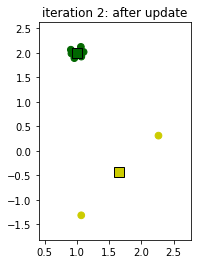

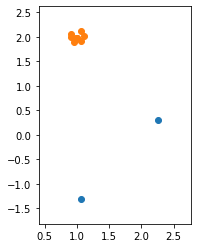

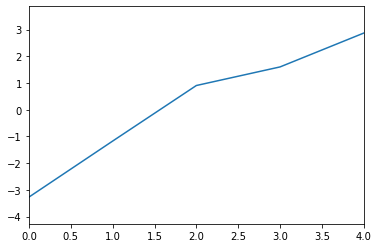

In [9]:
option = 7
data, K, m, n_iter, choice, first, second, xmin, xmax, ymin, ymax = Test_Cases(option)
#data = np.concatenate((np.random.normal(0, 0.05, (10,)), np.random.normal(1, 0.05, (10,)))).reshape((-1,1))
N, M = data.shape
just_last = True #parameter, if we only want to draw last
ret = EM(data, K, m, n_iter = n_iter, return_all_iterations=True, random_choice=choice)
plotting(ret, just_last)